<a href="https://colab.research.google.com/github/dundaremreozbirecikli/CNN-Brain-Tumor-Detection/blob/main/BrainTumorDetection_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries and Setup**

In [6]:
#!pip install -U tensorflow-addons
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.7 MB/s e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Preprocessing**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


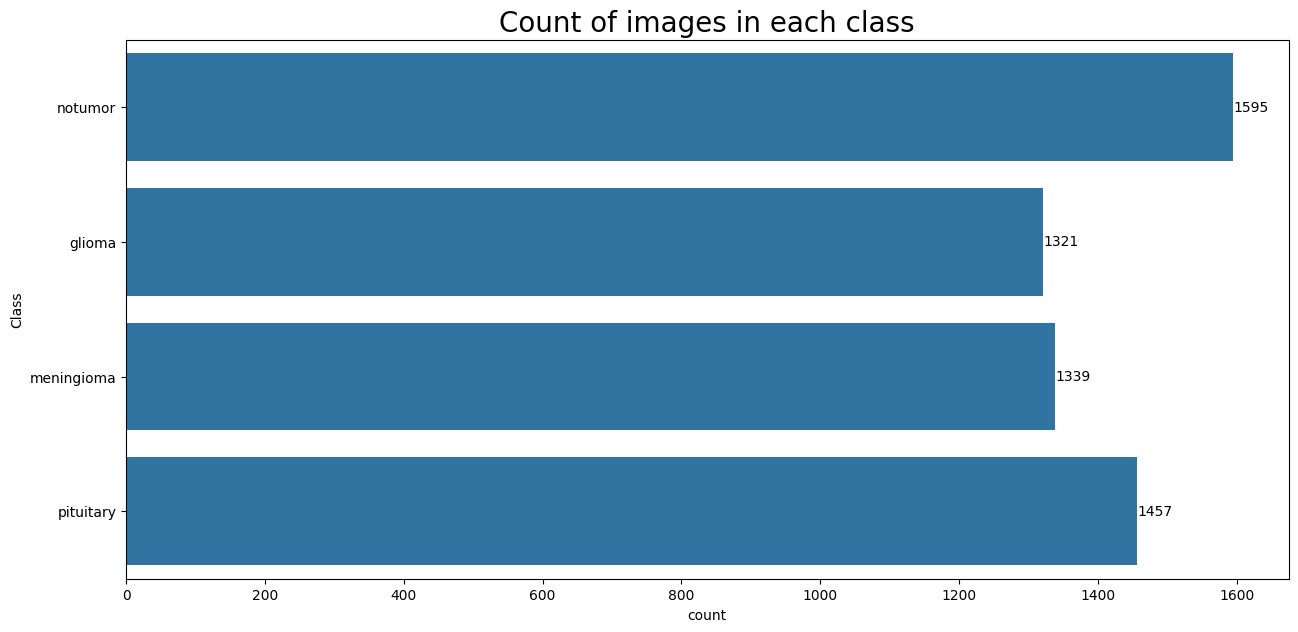

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from google.colab import drive


class DataPreprocessor:
    def __init__(self, train_path, test_path, output_directory):
        self.train_path = train_path
        self.test_path = test_path
        self.output_directory = output_directory

    def _convertToFrame(self, path):
        class_types = []
        class_paths = []

        files = os.listdir(path)
        for file in files:
            label_dir = os.path.join(path, file)
            if not os.path.isdir(label_dir):
                continue
            label = os.listdir(label_dir)
            for image in label:
                image_path = os.path.join(label_dir, image)
                class_paths.append(image_path)
                class_name = os.path.splitext(file)[0]
                class_types.append(class_name)
        image_classes = pd.Series(class_types, name='Class')
        image_paths = pd.Series(class_paths, name='Class Path')
        df = pd.concat([image_paths, image_classes], axis=1)
        return df

    def preprocessData(self):
        train_dframe = self._convertToFrame(self.train_path)
        test_dframe = self._convertToFrame(self.test_path)

        plt.figure(figsize=(15, 7))
        ax = sns.countplot(data=train_dframe, y=train_dframe['Class'])
        plt.title('Count of images in each class', fontsize=20)
        ax.bar_label(ax.containers[0])
        plt.show()

        valid_df, test_dframe = train_test_split(test_dframe, train_size=0.5, random_state=20, stratify=test_dframe['Class'])

        train_dframe.to_csv(os.path.join(self.output_directory, 'train_df.csv'), index=False)
        valid_df.to_csv(os.path.join(self.output_directory, 'valid_df.csv'), index=False)
        test_dframe.to_csv(os.path.join(self.output_directory, 'test_df.csv'), index=False)

if __name__ == "__main__":
    drive.mount('/content/drive')
    train_path = "/content/drive/MyDrive/dataset/Training"
    test_path = "/content/drive/MyDrive/dataset/Testing"
    output_directory = "/content/drive/MyDrive/dataset/"

    data_preprocessor = DataPreprocessor(train_path, test_path, output_directory)
    data_preprocessor.preprocessData()


# **Modelling and Training**

In [4]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
from google.colab import drive


class TrainModel:
    def __init__(self, train_df_path, valid_df_path, batch_size=128, img_size=(256, 256), epochs=6, model_output_path='./'):
        self.train_dframe = pd.read_csv(train_df_path)
        self.valid_dframe = pd.read_csv(valid_df_path)
        self.batch_size = batch_size
        self.image_size = img_size
        self.epochs = epochs
        self.model_output_path = model_output_path

    def _prepareDataGenerator(self):
        _gen = ImageDataGenerator(rescale=1.0/255,
                                  brightness_range=(0.8, 1.2),
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

        train_gen = _gen.flow_from_dataframe(self.train_dframe, x_col='Class Path',
                                             y_col='Class', batch_size=self.batch_size,
                                             target_size=self.image_size)

        valid_gen = _gen.flow_from_dataframe(self.valid_dframe, x_col='Class Path',
                                             y_col='Class', batch_size=self.batch_size,
                                             target_size=self.image_size)

        return train_gen, valid_gen

    def _buildModel(self):
        img_shape = (256, 256, 3)
        base_model = tf.keras.applications.Xception(include_top=False,
                                                    weights="imagenet",
                                                    input_shape=img_shape)

        model = Sequential([
            base_model,

            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), padding='same'),

            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), padding='same'),

            Conv2D(16, (3, 3), activation='relu', padding='same'),
            MaxPooling2D(pool_size=(2, 2), padding='same'),

            Flatten(),
            Dense(512, activation='relu'),
            Dropout(rate=0.3),

            Dense(128, activation='relu'),
            Dropout(rate=0.25),

            Dense(4, activation='softmax')
        ])

        model.compile(Adamax(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
        return model

    def trainModel(self):
        train_gen, valid_gen = self._prepareDataGenerator()
        model = self._buildModel()
        model.summary()

        with open(os.path.join(self.model_output_path, 'model_summary.txt'), 'w') as f:
            model.summary(print_fn=lambda x: f.write(x + '\n'))

        history = model.fit(train_gen,
                            epochs=self.epochs,
                            validation_data=valid_gen,
                            shuffle=False)

        model.save(os.path.join(self.model_output_path, 'brain_tumor_model.h5'))

        history_dict = history.history
        pd.DataFrame(history_dict).to_csv(os.path.join(self.model_output_path, 'training_history.csv'), index=False)


if __name__ == "__main__":
    drive.mount('/content/drive')
    train_df_path = '/content/drive/MyDrive/dataset/train_df.csv'
    valid_df_path = '/content/drive/MyDrive/dataset/valid_df.csv'
    model_output_path = '/content/drive/MyDrive/dataset/'

    model_trainer = TrainModel(train_df_path, valid_df_path, model_output_path=model_output_path)
    model_trainer.trainModel()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 32)          589856    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 32)          9248      
                                                                 
 m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Evaluation and Visualization**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 656 validated image filenames belonging to 4 classes.
6/6 [==============================] - 39s 6s/step


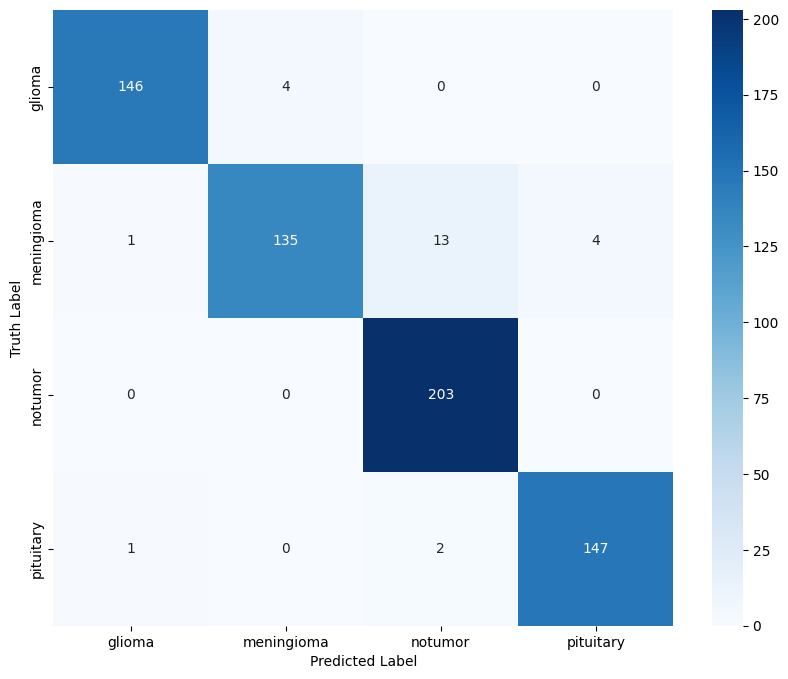

1/1 [==============================] - 1s 744ms/step


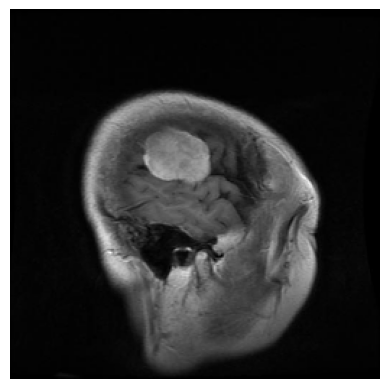

1/1 [==============================] - 0s 106ms/step


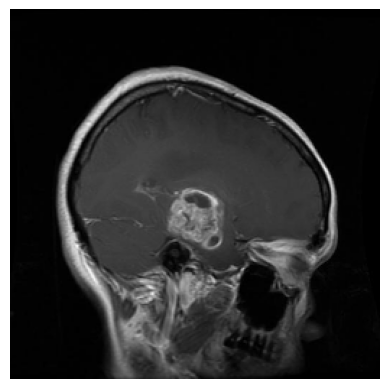

1/1 [==============================] - 0s 117ms/step


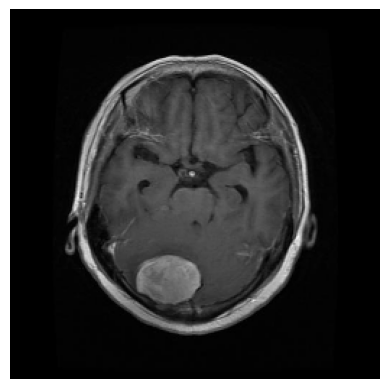

1/1 [==============================] - 0s 114ms/step


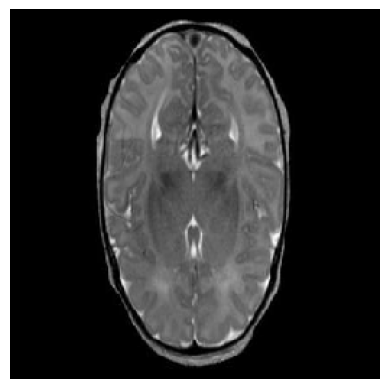

1/1 [==============================] - 0s 99ms/step


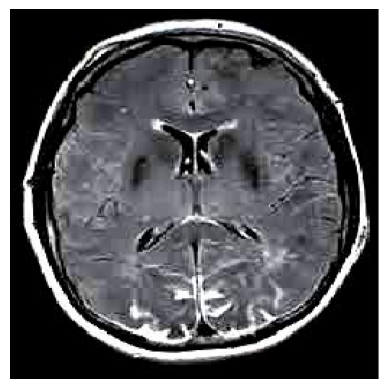

1/1 [==============================] - 0s 105ms/step


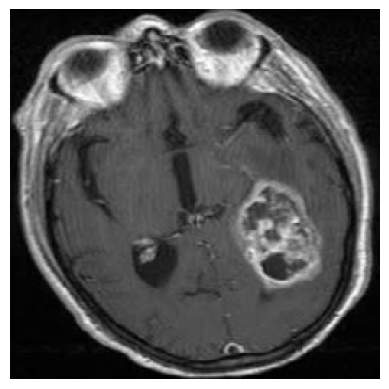

1/1 [==============================] - 0s 100ms/step


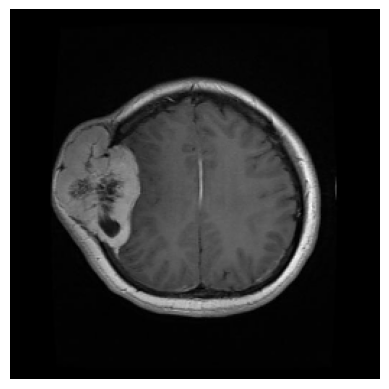

1/1 [==============================] - 0s 104ms/step


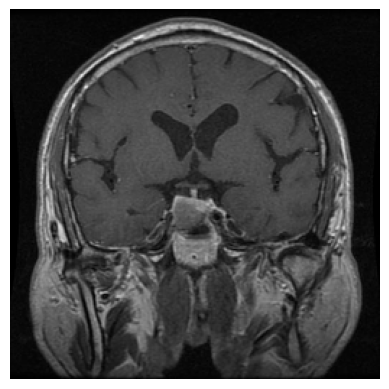

1/1 [==============================] - 0s 110ms/step


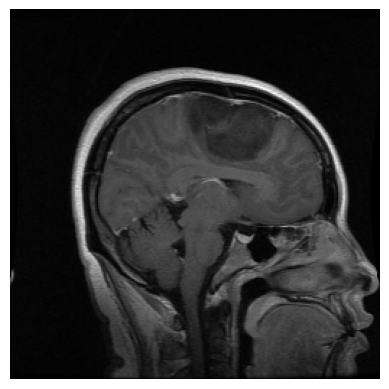

1/1 [==============================] - 0s 106ms/step


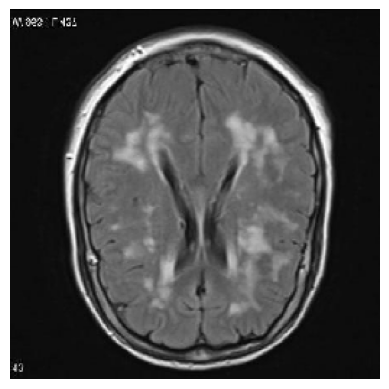

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
from google.colab import drive


class ModelEvaluate:
    def __init__(self, test_df_path, model_path, batch_size=128, img_size=(256, 256)):
        self.test_dframe = pd.read_csv(test_df_path)
        self.model_path = model_path
        self.batch_size = batch_size
        self.image_size = img_size

    def _prepareDataGen(self):
        test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(self.test_dframe,
                                                                           x_col='Class Path',
                                                                           y_col='Class',
                                                                           batch_size=self.batch_size,
                                                                           target_size=self.image_size,
                                                                           shuffle=False,
                                                                           class_mode='categorical')
        return test_gen

    def evaluateModel(self):
        test_gen = self._prepareDataGen()
        model = tf.keras.models.load_model(self.model_path)

        test_score = model.evaluate(test_gen, verbose=1)
        print(f"Test Loss: {test_score[0]}")
        print(f"Test Accuracy: {test_score[1]}")

        preds = model.predict(test_gen)
        y_pred = np.argmax(preds, axis=1)
        class_dict = test_gen.class_indices
        classes = list(class_dict.keys())

        print("Classification Report:")
        print(classification_report(test_gen.classes, y_pred, target_names=classes))

        cm = confusion_matrix(test_gen.classes, y_pred)
        labels = classes
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('Truth Label')
        plt.show()

        images_test, labels_test = next(iter(test_gen))

        for i in range(10):
            plt.imshow(images_test[i])
            plt.axis('off')

            prediction = np.argmax(model.predict(images_test[i][np.newaxis, ...]))
            actual_label = np.argmax(labels_test[i])

            print(f"Predicted Label: {classes[prediction]} and Actual Label: {classes[actual_label]}")
            plt.show()


if __name__ == "__main__":
    drive.mount('/content/drive')
    test_dframe_path = '/content/drive/MyDrive/dataset/test_df.csv'
    model_path = '/content/drive/MyDrive/dataset/brain_tumor_model.h5'

    evaluator = ModelEvaluate(test_dframe_path, model_path)
    evaluator.evaluateModel()


# **Brain Tumor Prediction**

In [7]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import drive


drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/dataset/brain_tumor_model.h5'
model = tf.keras.models.load_model(model_path)

class_labels_list = ['Glioma', 'Meningioma', 'No tumor', 'Pituitary']

def preprocessImage(image):
    image = image.convert("RGB")
    image = image.resize((256, 256))
    image = np.array(image)
    image = image / 255.0
    return image

def diagnosisPreidiction(image):
    image = preprocessImage(image)

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)

    predicted_class = np.argmax(predictions, axis=1)[0]

    diagnosis = class_labels_list[predicted_class]

    return diagnosis
#interface
interface = gr.Interface(
    fn=diagnosisPreidiction,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Brain Tumor Diagnosis",
    description="Upload the image of brain MRI and get diagnosis."
)

interface.launch()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0caed4de4a0aff3547.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
